In [ ]:
#Algorithmes pour séparer les couteurs en catégories et identifier les pics de performance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as pltlines
import matplotlib.colors as colors
import math
import statsmodels.tsa.filters.hp_filter as stat

import seaborn as sns
from datetime import datetime
import time
import scipy

In [2]:
def dens(dur,**kwargs):
    #calcule une densité d'un itérable
    #**kwargs vont etre redonnés à la fonction maptplotlib.pyplot.hist 
    #l'argument density est forcé à : True
    #input :  dur, itérable (liste, série...) de dimension 1 contenant les valeurs dont la densité nous intéresse
    #output : dens : array nupmy de dimension 2, dens[0] : abscisses des points, dens[1] : ordonnées des points
    
    kwargs['density'] = True
    h=plt.hist(dur, **kwargs)
    xhist = []
    plt.close()
    for i in range (len(h[1])-1):
        x = (h[1][i+1]+h[1][i])/2
        xhist.append(x)
    

    densite=np.zeros((2, len(xhist)))
    densite[0,:] = xhist
    densite[1,:] = h[0]
    return densite


In [3]:
def separate(densite):
    #prend en argument un array numpy de valeurs et sépare le signal en "tendance" et "bruit" avec un lambda de 0.1
    #input :  densite : array numpy de dimension 2, taille (k,n)
    #output : array nupmy de dimension 2, taille (k+1,n) où les 2 dernières lignes sont le bruit et la tendance de la derniere ligne de l'input
  
    b,t = stat.hpfilter(densite[-1,:],lamb = 0.1)
    result = np.zeros((len(densite)+1,len(densite[0])))
    result[0:len(densite),:]= densite
    result[-2]= b
    result[-1]=t
    return result



In [4]:
def lissage (x, sep=False, kind = 'cubic'): #sans **kwargs pour simplifier son utilisation
    #prend en argument un ensemble de points à interpoler stockés dans un array numpy et retourne la fonction d'interpolation cubique si kind = 'cubic' ou linéaire sinon
    # Input :    x : array numpy de dimension 2, taille(2,n) avec les abscisses des points à interpoler dans x[0] et leurs ordonnées dans x[1]
    #          sep : booléen. True si le signal doit être filtré par un HP filter
    # Output :   f : fonction d'une seule variable
    if sep ==True :
        t=separate(x)[2]
    else :
        t=x[1]
    if kind == 'cubic':
        poly = scipy.interpolate.splrep(x[0],t)
        def f (X):
            return(scipy.interpolate.splev(X,poly, der=0))
        
    else :
        interp=(scipy.interpolate.interp1d(x[0],t, kind='linear'))
        def f (X):
            return interp(X)
            
    return f

    

In [5]:
def perfgoals(A):
    #Fonction qui retrouve les pics de densité dans une distribution estimée, et les rend dans leur ordre d'importance
    #input :        A : array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés
    #output :  result : array numpy de dimension 2, taille (2,k) avec result[0] les abscisses des pics et result[1] les valeurs de la densite en ces points
    #                   l'output est trié par ordre d'importance (hauteur des pics)
    signal=separate(A)
    poly = scipy.interpolate.splrep(signal[0], signal[1])
    #derivee du bruit
    def f1(x): 
        return 1e2*scipy.interpolate.splev(x, poly, der = 1)
    #derivee seconde pour la concavite
    def f2(x):
        return 1e2*scipy.interpolate.splev(x, poly, der = 2)
    guess = signal[0] #on s'attend à ce que les points critiques soient proches des points où la é est mesurée
    roots = scipy.optimize.root(f1, guess).x #trouve les zéros de f1
#dans le cadre du cours, il est meilleur d'utiliser un pd.Series, et de sélectionner les valeurs à l'aide d'un vecteur booléen. plutôt que de travailler sur un array ou une liste
    r=pd.Series(roots)
    bools=abs(f1(r))<1e-4
#     print(f'bools : {bools}')
    r=r[bools]
#     print(f'vraies racines :\n{r}')
    #Les algorithmes de racines trouvent plusieurs fois les mêmes racines, à epsilon près. Supression des doublons:
    r=np.rint(r) #rint (entier le plus proche) permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
#     print(f'arrondis : {r}')
    r.drop_duplicates(inplace=True)
#     print(f'dédoubloné :\n{r}')
    r.sort_values(inplace=True)
#     print((f"sorted : \n{r}"))

    #élimination des valeurs hors bornes:
    bool1=r>A[0,0] 
    bool2=r<A[0,-1]
#     print(bool1)
#     print(bool2)
#     print(bool1*bool2)
    
    roots=list(r[bool1*bool2])
#     print(f"racines valables : {roots}")
#----------------------------- Ancienne méthode non robuste
#     print(f"racines : {roots}")
#     roots = list(set(np.rint(roots))) #floor permet de se limiter aux valeurs entieres et eliminer les doublons dus a scipy.optimize.root
#     print(f"floor : {roots}")
#     roots=sorted(roots) 
#     print((f"sorted : {roots}"))
#-----------------------------
    tops = []
    for i in range (len(roots)):
        if f2(roots[i])<0:       #selection des maximums parmi les points critiques
            tops.append(roots[i])
#     print(tops)
    realTops = []
    for i in tops:
        ind=np.argmin(abs(signal[0]-i))
#         print(f'Comparaison : {signal[0,ind]} , {i}')
        realTops=realTops+[signal[0, ind]]
        
    #tri par ordre d'importance    
    bruit = signal[0:2,:]
    g = lissage (bruit, sep=False, kind = 'linear') 
    values = g(realTops)
    sortedTops=np.take(realTops,np.argsort(values))
    sortedTops=np.flip(sortedTops)
    values = np.flip(np.sort(values))
    
    
    h = lissage (A, sep=False, kind = 'linear') #pour retrouver les vraies valeurs aux points approximés. Les vraies valeurs sont recalculées plutôt que lues
    result = np.zeros((2, len(sortedTops)))
    result[0,:]=sortedTops
    result[1,:]=h(sortedTops)
    
    return result
    
    

In [6]:
def topbotts(A, sort = 'performance'):
    #retourne une liste contenant les abscisses des maxima locaux et une autre contenant les abscisses des minima locaux
    #Inputs : A : array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés
    #      sort : façon de trier les outputs.
    #             -Soit par ordre croissant des abscisses ('performance') 
    #             -Soit par ordre croissant de courbure, les clusters les plus distincts ('values')
    #Outputs : tops, botts : tupple de listes d'abscisses contenant sommets et creux.
    
    signal=separate(A)
    
    poly = scipy.interpolate.splrep(signal[0], signal[2]) #interpolation polynomiale par morceaux de la tendance
    
    def f1(x):
        return 1e3*scipy.interpolate.splev(x, poly, der = 1) #derivee de la fonction de tendance
    def f2(x):
        return 1e3*scipy.interpolate.splev(x, poly, der = 2) #derivee seconde (pour tests de concavite)

    tendance = np.take(signal,[0,2], axis=0)
    guess = densite[0] #on s'attend à ce que les racines de f1 soient proches des abscisses originales, puisque les maximums originaux en font partie
    roots = scipy.optimize.root(f1, guess).x #trouve les points critiques de f
#    print(f"racines : {roots}\n")
    
    

#parfois, scipy.optimize.roots trouve des "racines" qui ne le sont pas il faut nettoyer ces données:

#dans le cadre du cours, il est meilleur d'utiliser un pd.Series, et de sélectionner les valeurs à l'aide d'un vecteur booléen. plutôt que de travailler sur un array ou une liste
    r=pd.Series(roots)
    bools=abs(f1(r))<1e-4
#     print(f'bools : {bools}')
    r=r[bools]
#     print(f'vraies racines :\n{r}')
    #Les algorithmes de racines trouvent plusieurs fois les mêmes racines, à epsilon près. Supression des doublons:
    r=np.rint(r) #rint (entier le plus proche) permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
#     print(f'arrondis : {r}')
    r.drop_duplicates(inplace=True)
#     print(f'dédoubloné :\n{r}')
    r.sort_values(inplace=True)
#     print((f"sorted : \n{r}"))

    #élimination des valeurs hors bornes:
    bool1=r>A[0,0] 
    bool2=r<A[0,-1]
#     print(bool1)
#     print(bool2)
#     print(bool1*bool2)
    
    roots=list(r[bool1*bool2])
#     print(f"racines valables : {roots}")
    tops = [] #selection des valeurs où f est concave : les maximums
    botts = []
    for i in range (len(roots)):
        if f2(roots[i])<0:
            tops.append(roots[i])
        else :
            botts.append(roots[i])


#     print(f'tops : {tops}') 
#     print(f'botts : {botts}') 
#partie si on veut obtenir les valeurs approchées par les abscisses originales.    
#     realTops = [] #valeur réelle la plus proche 
#     for i in tops:
#         ind=np.argmin(abs(tendance[0]-i))
#         print(f'Comparaison : {tendance[0,ind]} , {i}')
#         realTops=realTops+[tendance[0, ind]]
        
#     realBotts = []
#     for i in botts:
#         ind=np.argmin(abs(tendance[0]-i))
#         print(f'Comparaison : {tendance[0,ind]} , {i}')
#         realBotts=realBotts+[tendance[0, ind]]
        
#     tops=realTops
#     botts=realBotts

    botts=sorted(botts) #devrait être inutile par construction, mais comme scipy.optimize.roots est boîte-noire, je préfère le metttre.
    if sort == 'performance': #devrait être inutile par construction
        tops= sorted(tops)
#tri par ordre de courbure : plus la courbure (f2) est grande en norme, meilleurs sont les points (c'est à dire que la concentration est plus flagrante)
    if sort == 'values':
        values = f2(tops)
        ind=np.argsort(values)
        tops=np.take(tops, ind, axis=0)
        values = sorted(values)
#         print(f'values{values}')
#         print(f'tops{tops}')
    
    return tops, botts



In [7]:
def limiters (A, **kwargs):
    #forme les zones distinctes (catégories de coureurs) à partir de listes de sommets et creux:
    #Inputs : A : array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés
    #  **kwargs : arguments donnés à topbot. enpratique : sort='performance' ou sort='values'
    #Output : lim : liste de tupple avec les zones de forme [(inf1,sup1), (inf2,sup2)...]
    
    tops, botts=topbotts (A,**kwargs)

    
    lim = [] 
    for i in tops :
        under = A[0,0]
        test = False
        j=0
        while j <(len(botts)) and test==False:
            if botts[j]<i:
                under = botts[j]
                j+=1
            else:
                test=True

        over = A[0,-1]
        test=False
        j=len(botts)-1
        while j>=0 and test==False:
            if botts[j]>i:
                over = botts[j]
                j-=1
            else:
                test=True
        lim.append((under,over))
    print(lim)
    return lim

In [8]:
def taille_categorie(densi,limits):
    #calcule la proportions de coureurs dans une catégorie donnée par limits, arrondie au centième
    #Input : densi : Array numpy de dimension 2, taille (2,n) avec A[0] les abscisses et A[1] les ordonnées des points mesurés d'une densité
    #       limits : tuple de forme (borne_inf, forne_sup)
    #output : integ :float
    f=lissage(densi)
    integ=scipy.integrate.quad(f,limits[0],limits[1])
    return np.rint(100*integ[0])/100
    

In [9]:
data=pd.read_csv("10_km_Riorges.csv")

In [10]:
data.head()

,Athlète,Ligue,Performance,Naissance,Catégorie,time_delta,time_gap,duration,Nom,Prénom
0,LORTON Guillaume,ARA,N4,1989,SEM,0 days 00:30:58,0 days 00:00:00,1858.0,LORTON,Guillaume
1,BETRON Adrien,ARA,IR1,1989,SEM,0 days 00:31:30,0 days 00:00:32,1890.0,BETRON,Adrien
2,MOULIN Loic,ARA,IR2,1992,SEM,0 days 00:32:01,0 days 00:01:03,1921.0,MOULIN,Loic
3,DEBROUCKER Guillaume,ARA,IR2,1982,M1M,0 days 00:32:15,0 days 00:01:17,1935.0,DEBROUCKER,Guillaume
4,KEMEI Charles,ARA,IR2,1984,M0M,0 days 00:32:40,0 days 00:01:42,1960.0,KEMEI,Charles


In [11]:
dur=data['duration']
densite = dens(dur, bins = 12)


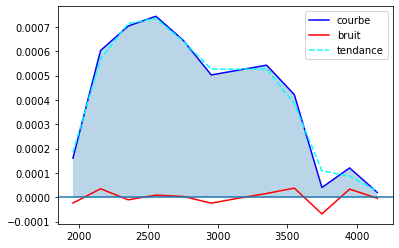

In [12]:
brten = separate(densite)
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],brten[1], color = "red", label = 'bruit')
plt.plot(brten[0],brten[2], color = "cyan", linestyle = 'dashed',label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)
plt.axhline(0)
plt.legend()
plt.show()


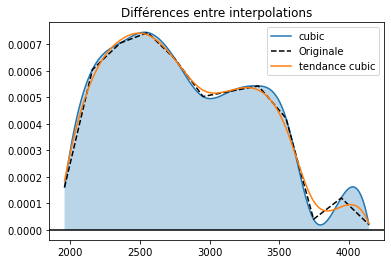

In [13]:
f=lissage(densite) 
g=lissage(densite, kind = 'linear') #l'originale
h=lissage(densite, kind = 'cubic', sep=True)

x=np.linspace(densite[0,0],densite[0,-1], int(1e5))
plt.fill_between(x,f(x), alpha = 0.3)
plt.plot(x,f(x), label = "cubic")
plt.plot(x,g(x), color = 'black', linestyle = 'dashed',label = "Originale")
plt.plot(x,h(x), label = "tendance cubic")
plt.axhline(0, color='black')
plt.legend()
plt.title('Différences entre interpolations')
plt.show()

In [14]:
#test de fonctionnement 1: densite orginale
print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))
# (0.9819998389448525, 1.329241666736536e-07) pour la 10km de Riorges
#l'interpolation linéaire fait lever un warning lors de l'intégration car elle est affine par morceaux.

#test de fonctionnement2: tendance de la densite interpolee 
print(scipy.integrate.quad(lambda x: lissage(densite, sep = True)(x),densite[0][0], densite[0][-1]))
#(0.9925168327790789, 6.901821989123772e-09) pour la 10km de Riorges

#l'interpolation cubique d'une fonction lissée donne une intégrale proche de 1 à 1e-2 pres, c'est satisfaisant.

C:\Users\tayoy\AppData\Local\Temp/ipykernel_28616/3680159937.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  print(scipy.integrate.quad(lambda x : lissage(densite,sep=False, kind = 'linear')(x),densite[0][0], densite[0][-1]))


(0.9819998389448525, 1.329241666736536e-07)
(0.9925168327790789, 6.901821989123772e-09)


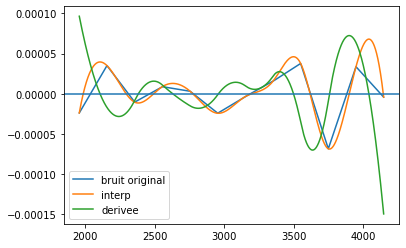

In [15]:
x= np.linspace(brten[0,0],brten[0,-1], int(1e5)) # abscisses du tracé

poly = scipy.interpolate.splrep(brten[0],brten[1]) #interpolation polynomiale par morceaux
def f0(x):
    return scipy.interpolate.splev(x, poly, der = 0) #fonction de bruit interpolee
def f1(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 1) #derivee de la fonction de bruit
def f2(x):
    return 1e2*scipy.interpolate.splev(x, poly, der = 2) #derivee seconde (pour tests de concavite)
bruit = brten[0:2,:]

g = lissage (bruit, sep=False, kind = 'linear')

h0 = f0(x)
h1 = f1(x)
plt.plot(x, g(x), label = 'bruit original')
plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.legend()
plt.axhline(0)


racines : [2106.52601419 2106.52604047 2381.76627902 2629.54163945 2629.54163945
 2957.56550944 3219.2365012  2957.56221805 3497.5151396  3756.00168176
 3756.00189644 4039.29051428]
floor : [2630.0, 4039.0, 3498.0, 3756.0, 2958.0, 2382.0, 3219.0, 2107.0]
sorted : [2107.0, 2382.0, 2630.0, 2958.0, 3219.0, 3498.0, 3756.0, 4039.0]
Comparaison : 2156.375 , 2107.0
Comparaison : 2554.208333333333 , 2630.0
Comparaison : 3548.7916666666665 , 3498.0
Comparaison : 3946.625 , 4039.0
pics : [2156.375, 2554.208333333333, 3548.7916666666665, 3946.625]


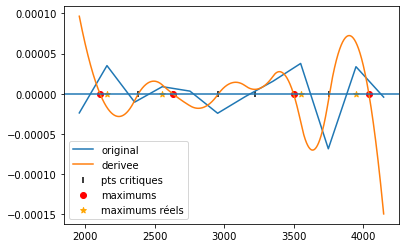

In [16]:
guess = densite[0] #on s'attend à ce que les racines de f1 soient proches des abscisses originales, puisque les maximums originaux en font partie

roots = scipy.optimize.root(f1, guess).x #trouve les points critiques de f
print(f"racines : {roots}")
#Les algorithmes de racines trouvent plusieurs fois les mêmes racines, à epsilon près. Supression des doublons:
roots = list(set(np.rint(roots))) #rint (entier le plus proche) permet de se limiter aux valeurs entières et eliminer les doublons dûs à scipy.optimize.root
print(f"floor : {roots}")
roots=sorted(roots)
print((f"sorted : {roots}"))

tops = [] #selection des valeurs où f est concave : les maximums
for i in range (len(roots)):
    if f2(roots[i])<0:
        tops.append(roots[i])
        
realTops = [] #valeur réelle la plus proche 
for i in tops:
    ind=np.argmin(abs(densite[0]-i))
    print(f'Comparaison : {densite[0,ind]} , {i}')
    realTops=realTops+[densite[0, ind]]

    

plt.plot(brten[0], brten[1], label = 'original')
#plt.plot(x,h0, label = 'interp')
plt.plot(x,h1, label = 'derivee')
plt.scatter(roots, [0]*len(roots), marker = '|', color = 'black', label = 'pts critiques')
plt.scatter(tops, [0]*len(tops), marker = 'o', color = 'red', label = 'maximums')
plt.scatter(realTops, [0]*len(realTops),marker = '*', color = 'orange', label = "maximums réels")
plt.axhline(0)
plt.legend()

print(f'pics : {realTops}')




In [17]:
perf=perfgoals(densite)
print(perf)

[[3.54879167e+03 2.15637500e+03 3.94662500e+03 2.55420833e+03]
 [4.22287390e-04 6.03267700e-04 1.20653540e-04 7.44030163e-04]]


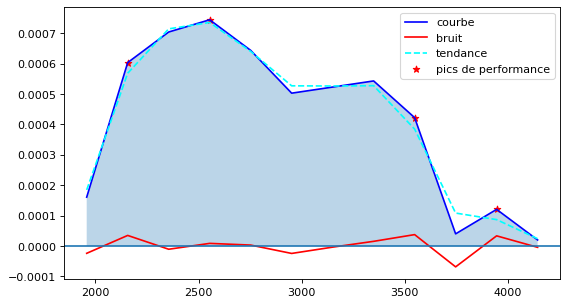

In [18]:
plt.figure(figsize=(8,4.5), dpi=80)
plt.plot(brten[0],densite[1], color = "blue", label = 'courbe')
plt.plot(brten[0],brten[1], color = "red", label = 'bruit')
plt.plot(brten[0],brten[2], color = "cyan", linestyle = 'dashed',label = 'tendance')
plt.fill_between(brten[0],densite[1], alpha=0.3)
plt.axhline(0)
plt.scatter(perf[0], perf[1], color='red', marker='*', label = "pics de performance")
plt.legend()
plt.show()

In [19]:
tops, botts = topbotts(densite, sort = 'performance')
lim = limiters(densite, sort='performance')

[(1957.4583333333333, 3036.0), (3036.0, 3848.0), (3848.0, 4145.541666666666)]


catégorie 1 : (1957.4583333333333, 3036.0)
catégorie 2 : (3036.0, 3848.0)
catégorie 3 : (3848.0, 4145.541666666666)


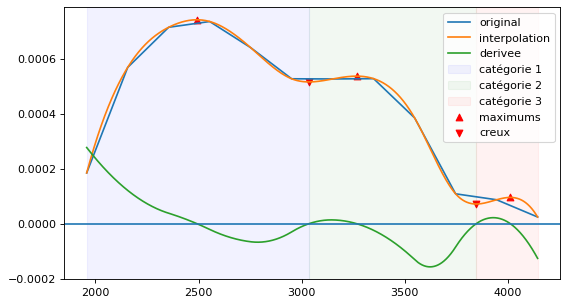

In [20]:
plt.figure(figsize=(8,4.5), dpi=80)
plt.plot(brten[0], brten[2], label = 'original')

poly=scipy.interpolate.splrep(brten[0],brten[2])
def f0 (x):
    return scipy.interpolate.splev(x,poly, der = 0)
def f1 (x):
    return 1e2*scipy.interpolate.splev(x,poly, der = 1)
def f2 (x):
    return 1e2*scipy.interpolate.splev(x,poly, der = 2)

plt.plot(x,f0(x), label = 'interpolation')
plt.plot(x,f1(x), label = 'derivee')

plt.scatter(tops, f0(tops), marker = '^', color = 'red', label = 'maximums')
plt.scatter(botts, f0(botts),marker = 'v', color = 'red', label = "creux")

cols = list(colors.BASE_COLORS.values())
for i in range(len(lim)):
    print(f'catégorie {i+1} : {lim[i]}')
    plt.axvspan(lim[i][0], lim[i][1], alpha = 0.05, color = cols[i], label = f'catégorie {i+1}')
    
plt.axhline(0)
plt.legend(loc='upper right')

In [22]:
taille_categorie(densite,lim[1]) 

0.31